# SPADE

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils
from torch.nn.utils import spectral_norm
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from torch.utils.data import DataLoader
from ds import MIBIDataset
import torch.nn.utils.spectral_norm as spectral_norm

from utilities import weights_init, seg_show

In [2]:
normalize = matplotlib.colors.Normalize(vmin=0, vmax=1)

torch.cuda.set_device(0)
gpu_available = True
channel_names = ["Pan-Keratin", "EGFR", "Beta catenin", "dsDNA",
                 "Ki67", "CD3", "CD8", "CD4", "FoxP3", "MPO", "HLA-DR", 
                 "HLA_Class_1", "CD209", "CD11b",  "CD11c", "CD68", "CD63",
                 "Lag3", "PD1", "PD-L1", "IDO", "Vimentin", "SMA", "CD31"]

# Parameters

In [3]:
# Learning rate for optimizers
batch_size = 32
nz = hidden_size = 128
kernel = 3

# Number of input channels (later to be number of classes)
num_chan = 18

# Size of feature maps in discriminator
ndf = 32

# Output dimension
nc = 24

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

c24_idx = np.array(range(25))
c24_idx = np.delete(c24_idx, 4)

# Read In Data

In [5]:
# train data
cells_seg = []
cells_real = []
keys = []

path = './data'
filelist = os.listdir(path + '/train')

for i in range(int(len(filelist[:]))): # have both counts and cells
    patch = path + '/train/cell_' + str(i) + '.npy'
    cells_seg.append(np.load(patch)[0])
    cells_real.append(np.load(patch)[1][c24_idx])

print('number of total cells: %d' % (len(cells_seg))) 

cells_seg = np.array(cells_seg)
empty = np.less(np.sum(cells_seg, axis=1, keepdims=True), 0.5).astype(np.float32)
cells_seg = np.concatenate([cells_seg, empty], axis=1)


cells_real = np.array(cells_real) 
cells = np.array([[cells_seg[i], cells_real[i]] for i in range(len(cells_seg))])

train_set_loader = DataLoader(MIBIDataset(cells), batch_size=batch_size, 
                       shuffle=True, num_workers=4, pin_memory=gpu_available)

patient: 14, number of total cells: 5648


In [5]:
# test data

cells_seg = []
cells_real = []
keys = []

path = './data'
filelist = os.listdir(path + '/test')

for i in range(int(len(filelist[:]))): # have both counts and cells
    patch = path + '/test/cell_' + str(i) + '.npy'
    cells_seg.append(np.load(patch)[0])
    cells_real.append(np.load(patch)[1][c24_idx])

print('number of total cells: %d' % (len(cells_seg))) 


cells_seg = np.array(cells_seg)
empty = np.less(np.sum(cells_seg, axis=1, keepdims=True), 0.5).astype(np.float32)
cells_seg = np.concatenate([cells_seg, empty], axis=1)

cells_real = np.array(cells_real)
cells = np.array([[cells_seg[i], cells_real[i]] for i in range(len(cells_seg))])

test_set_loader =  DataLoader(MIBIDataset(cells), batch_size=1, 
                       shuffle=True, num_workers=4, pin_memory=gpu_available)


patient: 14, number of total cells: 446


# Spade

In [6]:
# kind of batch normalization, k should have same size with input channels

class SPADE(nn.Module):
    def __init__(self, input_size, filters=128, kernel_size=3, num_chan=num_chan):
        super().__init__()
        output_size = input_size
        self.conv = nn.Conv2d(num_chan, filters, kernel_size=(kernel_size, kernel_size), 
                              padding=1)
        
        self.conv_gamma = nn.Conv2d(filters, output_size, kernel_size=(kernel_size, kernel_size), 
                                    padding=1)
        
        self.conv_beta = nn.Conv2d(filters, output_size, kernel_size=(kernel_size, kernel_size), 
                                   padding=1)

        self.norm = nn.InstanceNorm2d(output_size, affine=False)
        
    def forward(self, x, seg):
        N, C, H, W = x.size()

        x = self.norm(x)
        
        seg = F.interpolate(seg, size=(H,W), mode='nearest')
        shared = F.relu(self.conv(seg))
        
        seg_gamma = self.conv_gamma(shared)
        seg_beta = self.conv_beta(shared)
        x = x * (1 + seg_gamma) + seg_beta

        return x

# Generator

In [7]:
class ResnetBlock(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size=3):
        super(ResnetBlock, self).__init__()
        
        self.if_shortcut = (dim_in != dim_out)
        dim_middle = min(dim_in, dim_out)
        
        self.conv1 = spectral_norm(nn.Conv2d(in_channels=dim_in, out_channels=dim_middle,
                                   kernel_size=kernel_size, padding=1))
        self.conv2 = spectral_norm(nn.Conv2d(in_channels=dim_middle, out_channels=dim_out,
                                   kernel_size=kernel_size, padding=1))
        
        if self.if_shortcut:
            self.convs = spectral_norm(nn.Conv2d(dim_in, dim_out, kernel_size=1, bias=False))

        self.norm1 = SPADE(dim_in)
        self.norm2 = SPADE(dim_middle)
        if self.if_shortcut:
            self.norms = SPADE(dim_in)

    def forward(self, x, seg):

        xs = self.shortcut(x, seg)

        dx = self.conv1(self.actvn(self.norm1(x, seg)))
        dx = self.conv2(self.actvn(self.norm2(dx, seg)))

        out = xs + dx

        return out
        
        
    def shortcut(self, x, seg):
        if self.if_shortcut:
            xs = self.convs(self.norms(x, seg))
        else:
            xs = x
        return xs
    
    def actvn(self, x):
        return F.leaky_relu(x, 0.2)     


In [8]:
class ChannelGenerator(nn.Module):
    
    def __init__(self,
                num_chan = num_chan,
                nc = nc):
        super().__init__()
        
#         self.num_chan = num_chan
        
        self.ups = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.linear = nn.Linear(128, 2048)
        
        self.resblk_1 = ResnetBlock(128,  128)   # (8,8)
        self.resblk_2 = ResnetBlock(128,  128)   # (16,16)
        self.resblk_3 = ResnetBlock(128,  64)   # (32,32)
        self.resblk_4 = ResnetBlock(64,  32)   # (64,64)
        
        self.final = nn.Conv2d(32, nc, kernel_size=3, padding=1)
        
        
    def forward(self, x, seg, n1=None, n2=None):

        curr_size = x.size(0)
    
        x = self.linear(x)
        x = x.view(-1, 128, 4 ,4)
        
        x = self.ups(x)
        x = self.resblk_1(x,seg)
        
        x = self.ups(x)
        x = self.resblk_2(x,seg)
        
        x = self.ups(x)
        x = self.resblk_3(x,seg)
        
        x = self.ups(x)
        x = self.resblk_4(x,seg)
        
        x = self.final(F.leaky_relu(x, 0.2))
        
        return nn.Sigmoid()(x)
        # return x

# Discriminator

In [9]:
class DiscriminatorBase(nn.Module):
    def __init__(self,
                 ndf=ndf,
                 num_chan=num_chan, 
                 batch_size=batch_size,
                 nz=nz,
                 nc=nc):
        super(DiscriminatorBase, self).__init__()

        self.layer1 = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(num_chan + nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=False))
        
        self.layer2 = nn.Sequential(
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=False))
        
        self.layer3 = nn.Sequential(
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=False))
        
        self.layer4 = nn.Sequential(
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=False))
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(ndf * 8, ndf * 16, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=False))
            
        
        self.layer6 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 16, 1, kernel_size=3, stride=2, padding=1),
            nn.Sigmoid()
        )

        self.feature_maps = []
        
    def forward(self, input, X_seg):
        x = torch.cat([input, X_seg], dim=1)
        
        x = self.layer1(x)
        self.feature_maps.append(x)
        
        x = self.layer2(x)
        self.feature_maps.append(x)
        
        x = self.layer3(x)
        self.feature_maps.append(x)
        
        x = self.layer4(x)
        self.feature_maps.append(x)
        
        x = self.layer5(x)
        self.feature_maps.append(x)
        
        x = self.layer6(x)
        # self.feature_maps.append(x)
        
        return x
    
    def reset(self):
        self.feature_maps = []


# Training

In [11]:
netG = ChannelGenerator().float().cuda()
netD = DiscriminatorBase().float().cuda()

optimizerG = optim.Adam(netG.parameters(), lr=0.0008)
optimizerD = optim.Adam(netD.parameters(), lr=0.0001)

netG.apply(weights_init)
netD.apply(weights_init)

# Initialize loss functions
criterionG = nn.MSELoss()
criterionD = nn.MSELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

print("Initialized")

Initialized


/home/ubuntu/MIBI/full/utilities.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data)


In [ ]:
# Training Loop
num_epochs = 120

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
R_losses = []
iters = 0

d_iters = 1
g_iters = 1

print("Starting Training Loop...")
# For each epoch
for epoch in range(1, num_epochs):
    if epoch % 100 == 0:
        for param_group in optimizerG.param_groups:
                param_group['lr'] /= 2
        for param_group in optimizerD.param_groups:
                param_group['lr'] /= 2
                
                
    for idx, data in enumerate(train_set_loader):
        
        X_seg, X_real = data
        X_seg = torch.clamp(X_seg.transpose(2,1), 0, 1).float().cuda()
        X_real = X_real.transpose(2,1).float().cuda()
        
        ## Train with all-real batch
        for _ in range(d_iters):
            netD.zero_grad()
            
            output = netD(X_real, X_seg)
            label = torch.full(output.size(), real_label).cuda()
            
            errD_real = criterionD(output, label)
            errD_real.backward()
            
            D_x = output.mean().item()
            
            noise = 0.5 * torch.randn(X_seg.size()[0], 128).cuda()
            fake = netG(noise, X_seg.detach())
            label.fill_(fake_label)
            output = netD(fake.detach(), X_seg.detach())
            errD_fake = criterionD(output, label)
            errD_fake.backward()
            
            D_G_z1 = output.mean().item()

            errD = errD_real + errD_fake 
            
            optimizerD.step()
                
            netD.zero_grad()
            netD.reset()
            
        for _ in range(g_iters):
            netG.zero_grad()
            
            fake = netG(noise, X_seg.detach())
            label.fill_(real_label)
            
            output = netD(fake, X_seg.detach())
            errG = criterionD(output, label)
            
            # feature matching loss
            D_fm_fake = netD.feature_maps   # fake feature map
            netD.reset()
            
            output_real = netD(X_real.detach(), X_seg.detach()).view(-1)
            D_fm_real = netD.feature_maps   # real feature map
            netD.reset()
            
            D_fm_loss = 0
            for i in range(len(D_fm_fake)):
                D_fm_loss += nn.L1Loss()(D_fm_fake[i], D_fm_real[i])
               
            r_loss = D_fm_loss
            Lambda = 10
            errG += Lambda*D_fm_loss
            
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()
            
            
            
        if idx % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss_R: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, idx, len(train_set_loader),
                     errD.item(), errG.item(), r_loss.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        
    if epoch % 5 == 1:
        
        fig=plt.figure(figsize=(2.5, 2.5))
        print("Segmentation: ")
        plt.imshow(seg_show(X_seg.detach().cpu().numpy()[0]))
        plt.show()
        
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Fake: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(fake.detach().cpu().numpy()[0][i],cmap='hot', interpolation='nearest')
        plt.show()
        
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Real: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow( X_real[0,i,:,:].detach().cpu().numpy(),cmap='hot', interpolation='nearest')
        plt.show()
        
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Scaled Fake: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(fake.detach().cpu().numpy()[0][i],cmap='hot', interpolation='nearest', norm=normalize)
        plt.show()
        
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Scaled Real: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(X_real[0,i,:,:].detach().cpu().numpy(),cmap='hot', interpolation='nearest', norm=normalize)
        plt.show()

 

    if epoch % 20 == 1:
        print("============================")
        print("test cell")
        print("============================")
        
        for idx, data in enumerate(test_set_loader):
        
            X_seg, X_real = data
            X_seg = torch.clamp(X_seg.transpose(2,1), 0, 1).float().cuda()
            X_real = X_real.transpose(2,1).float().cuda()
            noise = 0.5 * torch.randn(X_seg.size()[0], 128).cuda()
            break
        
        
        fake = netG(noise, X_seg.detach())
            
        fig=plt.figure(figsize=(2.5, 2.5))
        print("Segmentation: ")
        plt.imshow(seg_show(X_seg.detach().cpu().numpy()[0]))
        plt.show()
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Fake: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(fake.detach().cpu().numpy()[0][i],cmap='hot', interpolation='nearest')
        plt.show()
        
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Real: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow( X_real[0,i,:,:].detach().cpu().numpy(),cmap='hot', interpolation='nearest')
        plt.show()
        
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Scaled Fake: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(fake.detach().cpu().numpy()[0][i],cmap='hot', interpolation='nearest', norm=normalize)
        plt.show()
        
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Scaled Real: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(X_real[0,i,:,:].detach().cpu().numpy(),cmap='hot', interpolation='nearest', norm=normalize)
        plt.show()


# Save & Load Model

In [ ]:
state = {
    'epoch': epoch,
    'G': netG.state_dict(),
    'optimizerG': optimizerG.state_dict(),
    'D' : netD.state_dict(),
    'optimizerD' : optimizerD.state_dict()
}
torch.save(state, './model/baseline_spade')

In [10]:
netG = ChannelGenerator().float().cuda()
state = torch.load('./model/baseline_spade')
netG.load_state_dict(state['G'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

# Reconstruction Metrics

# Adjusted L1

In [ ]:
# Adjust L1

Loss = 0
AdjLoss  = 0
for idx, data in enumerate(test_set_loader):

    X_seg, X_real = data
    X_seg = torch.clamp(X_seg.transpose(2,1), 0, 1).float().cuda()
    X_real = X_real.transpose(2,1).float().cuda()
    X_mask = (1 - X_seg[:,-1]).unsqueeze(1)
    noise = 0.5 * torch.randn(X_seg.size()[0], 128).cuda()
    fake = netG(noise, X_seg).detach()
    outside = (1 - X_mask) * fake
    
    B,C = X_real.size()[:2]
    real_data = (X_mask*X_real).view(B, C, -1)
    fake_data = (X_mask*fake).view(B, C, -1)
    # print(real_data.shape)
    
    real_rank, _ = torch.sort(real_data, dim=2)
    fake_rank, _ = torch.sort(fake_data, dim=2)
    
    Loss += nn.L1Loss()(real_rank[:], fake_rank[:])
    AdjLoss += nn.L1Loss()(real_rank[:], fake_rank[:])
    AdjLoss += nn.L1Loss()(outside[:], torch.zeros_like(outside[:]))
    
print('spade Adjust L1 Metric:', AdjLoss.item())
print('spade Pure L1 Metric:', Loss.item())

# Adjusted MSE 

In [18]:
# Adjust MSE

Loss = 0
AdjLoss  = 0
for idx, data in enumerate(test_set_loader):

    X_seg, X_real = data
    X_seg = torch.clamp(X_seg.transpose(2,1), 0, 1).float().cuda()
    X_real = X_real.transpose(2,1).float().cuda()
    X_mask = (1 - X_seg[:,-1]).unsqueeze(1)
    noise = 0.5 * torch.randn(X_seg.size()[0], 128).cuda()
    fake = netG(noise, X_seg).detach()
    outside = (1 - X_mask) * fake
    
    B,C = X_real.size()[:2]
    real_data = (X_mask*X_real).view(B, C, -1)
    fake_data = (X_mask*fake).view(B, C, -1)
    # print(real_data.shape)
    
    real_rank, _ = torch.sort(real_data, dim=2)
    fake_rank, _ = torch.sort(fake_data, dim=2)
    
    Loss += nn.MSELoss()(real_rank[:], fake_rank[:])
    AdjLoss += nn.MSELoss()(real_rank[:], fake_rank[:])
    AdjLoss += nn.MSELoss()(outside[:], torch.zeros_like(outside[:]))
    
print('spade Adjust MSE Metric:', AdjLoss.item())
print('spade Pure MSE Metric:', Loss.item())

spade Adjust L1 Metric: 0.030705349519848824
spade Pure L1 Metric: 0.030625656247138977


# SSIM

In [12]:
cells_seg_list = []
cells_real_list = []

download_path = './data/benchmark'
filelist = os.listdir(download_path)

for i in range(len(filelist)):
    patch = download_path + '/cell_' + str(i) + '.npy'
    cells_seg_list.append(np.load(patch)[0])
    cells_real_list.append(np.load(patch)[1])

In [32]:
from skimage.measure import compare_ssim

ssim_score = 0
ssim_channels = np.zeros(nc)

for c in range(len(cells_seg_list)):
    
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    noise = 0.5 * torch.randn(1, 128).cuda()
    
    # seg_test = 0
    seg_test = np.sum(seg_list, axis=0)
    empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
    seg_test_18 = np.concatenate([seg_test, empty], axis=0)
    X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
    
    # fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
    fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
    
    # fake = netF(fake, X_seg_0)
    for j in range(nc):
        fake_i = fake[j].astype(float)
        real_i = np.sum(real_list, axis=0)[j].astype(float)  # i-th cell, j-th channel

        # plt.imshow(fake_i)
        # plt.show()
        # plt.imshow(real_i)
        # plt.show()
        ssim_score += compare_ssim(fake_i, real_i)/nc
        ssim_channels[j] += compare_ssim(fake_i, real_i)

print('ssim score:', ssim_score/len(cells_seg_list))
for j in range(nc):
    print(channel_names[j], ssim_channels[j]/len(cells_seg_list))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


ssim score: 0.9533247637391726
Pan-Keratin 0.8884157697420001
EGFR 0.9959946974098162
Beta catenin 0.7895202821761088
dsDNA 0.8148255447081495
Ki67 0.9924888667205016
CD3 0.972576310411545
CD8 0.9709910606581553
CD4 0.9961643471596012
FoxP3 0.9999483714801959
MPO 0.9993480908794583
HLA-DR 0.9792498604669935
HLA_Class_1 0.7312995687115973
CD209 0.9999686589392875
CD11b 0.9990996766508632
CD11c 0.9960643942418373
CD68 0.9907117917485699
CD63 0.9944712732944291
Lag3 0.9980195748531716
PD1 0.9791280682231944
PD-L1 0.8755976465654229
IDO 0.9989636828140451
Vimentin 0.943145238918583
SMA 0.974982341297089
CD31 0.9988192116695163


# Cell Based MI

In [23]:
def mutual_information(hgram):
    """ Mutual information for joint histogram
    """
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

In [ ]:
total_mi = 0
n_bin = 50
mi_channels = np.zeros(nc)

for c in range(len(cells_seg_list)):
    
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    noise = 0.5 * torch.randn(1, 128).cuda()
    
    # seg_test = 0
    seg_test = np.sum(seg_list, axis=0)
    empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
    seg_test_18 = np.concatenate([seg_test, empty], axis=0)
    X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
    
    fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
    
    for i in range(n_cell):
        mask = seg_list[i].sum(axis=0)
        
        for j in range(nc):
            fake_i = (fake*mask)[j].flatten()
            real_i = real_list[i][j].flatten()   # i-th cell, j-th channel
            
            hist_2d, _, _ = np.histogram2d(fake_i, real_i, bins=n_bin)

            mi = mutual_information(hist_2d)
            mi_channels[j] += mi/n_cell/nc
            total_mi += mi/n_cell/nc
            
print('mutual information:', total_mi)
for j in range(nc):
    print(channel_names[j], mi_channels[j])

# Biological Significant

# Center of Mass

In [10]:
cells_seg_list = []
cells_real_list = []

download_path = './data/cd8_test_c24'
filelist = os.listdir(download_path)

for i in range(len(filelist)):
    patch = download_path + '/cell_' + str(i) + '.npy'
    cells_seg_list.append(np.load(patch)[0])
    cells_real_list.append(np.load(patch)[1])

In [41]:
cm_score = 0

for c in range(len(cells_seg_list)):
    
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    xy = np.mgrid[0:64,0:64]
    noise = 0.5 * torch.randn(1, 128).cuda()
    
    # seg_test = 0
    seg_test = np.sum(seg_list, axis=0)
    empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
    seg_test_18 = np.concatenate([seg_test, empty], axis=0)
    X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
    
    
    fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        
    fake_tcell = fake * seg_list[0].sum(axis=0)    # only consider the expression in T cells
    fake_tumor = fake * (seg_test-seg_list[0]).sum(axis=0)    # only consider the expression in tumor cells

    cm_tumor_y = (xy[0]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
    cm_tumor_x = (xy[1]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
    cm_tumor = np.array([cm_tumor_x, cm_tumor_y])
    
    tcell_mask = seg_list[0].sum(axis=0)
    tcell_seg = np.array(np.where(tcell_mask==1))
    dist = np.linalg.norm(tcell_seg - cm_tumor[:, 19:20], axis=0)
    cm_idx = np.argmin(dist)
    cm_tumor_incell = tcell_seg[:, cm_idx]
    
    
    cm_tcell_y = (xy[0]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
    cm_tcell_x = (xy[1]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
    cm_tcell = np.array([cm_tcell_x, cm_tcell_y])

    
    cm_score += np.linalg.norm(cm_tcell[:,18] - cm_tumor_incell[:], ord=2)
    # cm_score += np.linalg.norm(cm_tcell[:,19] - cm_tumor[:,20], ord=2)
    
print('center of mass score:', cm_score / len(cells_seg_list))

center of mass score: 10.709831983085161


# EM Distance

In [12]:
from scipy.stats import wasserstein_distance

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    if phi < 0:
        phi = 2*np.pi + phi
        
    return (rho, phi)


def compute_histogram(img, divider=30, size = 64, offset=32):

    histogram = np.zeros([divider])

    for i in range(size):
        for j in range(size):
            x = j - offset
            y = offset - i
            
            rho, phi = cart2pol(x,y)
            # normalize to [0,divider]
            degree = divider * phi/(2*np.pi) 
            index = int(np.floor(degree))
            histogram[index] += img[i,j]
            
    return histogram

In [ ]:
# EM score threshold
em_score = 0
direct_right = 0
direct_wrong = 0
direct_all = 0

for c in range(len(cells_seg_list)):

    
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    noise = 0.5 * torch.randn(1, 128).cuda()
    
    seg_test = 0
    xy = np.mgrid[0:64,0:64]
    centroids_seg = []
    centroids_tcell = []
    centroids_tumor = []
    express_tcell = []
    for i in range(n_cell):

        # non-weighted centroid of segmentation
        cy = np.where(seg_list[i]==1)[1].mean()
        cx = np.where(seg_list[i]==1)[2].mean()
        centroids_seg.append(np.array([cx, cy]))

        # weighted centroid of T cells
        seg_test += seg_list[i]
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
        
        fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        
        fake_tcell = fake * seg_list[0].sum(axis=0)    # only consider the expression in T cells
        fake_tumor = fake * seg_list[i].sum(axis=0)    # only consider the expression in tumor cells
        # fake_tumor = fake * (seg_test-seg_list[0]).sum(axis=0)
        histo_cur = compute_histogram(fake_tcell[18])
        
        # weighted centroid of T cells
        cy_all = (xy[0]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
        cx_all = (xy[1]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
        centroids_tcell.append(np.array([cx_all, cy_all]))

        
        # weighted centroid of tumor cells
        cy_all = (xy[0]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
        cx_all = (xy[1]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
        centroids_tumor.append(np.array([cx_all, cy_all]))
        
        # print(fake_tumor[19].sum())
        
        if i > 0 and fake_tumor[19].sum() > 1e-4:
            
            direct_all += 1
            # the previous angle
            
            v1 = (centroids_tumor[i][:,19] - centroids_seg[0])    # previous centroid of T cell            
            v2 = (centroids_tcell[i][:,18] - centroids_tcell[i-1][:,18])    # current centroid of T cell
            
            if i == 1: # no work so much
                v2 = (centroids_tcell[i][:,18] - centroids_seg[0])
                
            cos_theta = np.dot(v1,v2)/np.linalg.norm(v1)/np.linalg.norm(v2)
            
            em_dist = wasserstein_distance(histo_cur, histo_pre)
            
            
            if cos_theta > 0:
                direct_right += 1
                
            elif cos_theta < 0:
                direct_wrong += 1
                
            if cos_theta > 0 and histo_cur.sum() > histo_pre.sum():   # threshold the theta / check the expression level
                em_score +=  np.linalg.norm(v2) * em_dist
                
            elif cos_theta < 0:
                em_score -= np.linalg.norm(v2) * em_dist
        
        histo_pre = histo_cur.copy()  
        
print("Direction: right:{}, wrong:{}, total:{}".format(direct_right, direct_wrong, direct_all))

print("em_score:{}".format(em_score))

# Pan-Keratin / CD8 Experiment

In [11]:
cells_seg_list = []
cells_real_list = []

download_path = './data/cd8_test_c24'
filelist = os.listdir(download_path)

for i in range(len(filelist)):
    patch = download_path + '/cell_' + str(i) + '.npy'
    cells_seg_list.append(np.load(patch)[0])
    cells_real_list.append(np.load(patch)[1])

In [12]:
# CD8 Test
noise = 0.5 * torch.randn(1, 128).cuda()
total = 0
decrease = 0


surface_area = []
tumor_expression = []

for c in range(len(cells_seg_list)):
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    
    for k in range(1, n_cell):
    
        seg_tumor = np.sum(seg_list[0], axis=0)
        seg_test = np.zeros([17, 64, 64])
        seg_test[4] = seg_tumor    # tumor
        
        seg_cd8 = 0
        if k == 0:
            seg_test[7] =  0   # cd8
        else:
            seg_cd8 = np.sum(seg_list[1:k+1], axis=0).sum(0)
            seg_test[7] = seg_cd8    # cd8
         
        
        
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()

        fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        
        pk_cur = (fake[0]*seg_tumor).sum()/ seg_tumor.sum()
 
        surface_area.append(seg_cd8.sum())
        tumor_expression.append(pk_cur)
        

slop after normalization: 0.003338708318154775


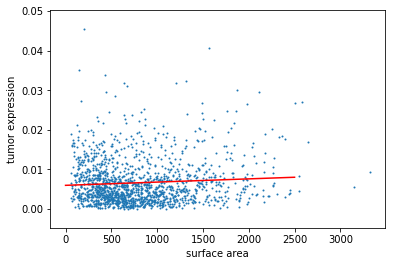

In [13]:
x = np.array(surface_area)
y = np.array(tumor_expression)

plt.xlabel('surface area')
plt.ylabel('tumor expression')
plt.scatter(x,y,s=1)


from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x.reshape(-1,1), y.reshape(-1,1))
t = np.arange(0,2500).reshape(-1,1)
y_t = reg.predict(t)
plt.plot(t,y_t,'r')
print('slop after normalization:',reg.coef_[0][0]*(64*64))

plt.show()

In [14]:
# CD8 Test: Tumor Controll
noise = 0.5 * torch.randn(1, 128).cuda()
total = 0
decrease = 0


surface_area = []
tumor_expression = []

for c in range(len(cells_seg_list)):
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    
    for k in range(1, n_cell):
    
        seg_tumor = np.sum(seg_list[0], axis=0)
        seg_test = np.zeros([17, 64, 64])
        seg_test[4] = seg_tumor    # tumor
        
        seg_cd3 = 0
        if k>0:
            seg_cd3 = np.sum(seg_list[1:k+1], axis=0).sum(0)
            seg_test[4] += seg_cd3    # cd8
        
        
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()

        fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        
        pk_cur = (fake[0]*seg_tumor).sum() / seg_tumor.sum()
 
        surface_area.append(seg_cd3.sum())
        tumor_expression.append(pk_cur)
        

slop after normalization: 0.003808254142054597


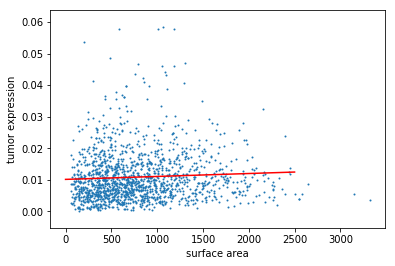

In [15]:
x = np.array(surface_area)
y = np.array(tumor_expression)

plt.xlabel('surface area')
plt.ylabel('tumor expression')
plt.scatter(x,y,s=1)


from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x.reshape(-1,1), y.reshape(-1,1))
t = np.arange(0,2500).reshape(-1,1)
y_t = reg.predict(t)
plt.plot(t,y_t,'r')
print('slop after normalization:',reg.coef_[0][0]*(64*64))

plt.show()

In [19]:
# CD8 Test
noise = 0.5 * torch.randn(1, 128).cuda()
total = 0
decrease = 0


cell_num = []
tumor_expression = []

for c in range(len(cells_seg_list)):
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    
    for k in range(1, n_cell):
    
        seg_tumor = np.sum(seg_list[0], axis=0)
        seg_test = np.zeros([17, 64, 64])
        seg_test[4] = seg_tumor    # tumor
        
        
        if k == 0:
            seg_test[7] =  0   # cd8
        else:
            seg_cd3 = np.sum(seg_list[1:k+1], axis=0).sum(0)
            seg_test[7] = seg_cd3    # cd8

        
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()

        fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        
        pk_cur = (fake[0]*seg_tumor).sum() / seg_tumor.sum()
        
        cell_num.append(k)
        tumor_expression.append(pk_cur)
        

In [20]:
n_max = np.max(cell_num)
x_mean = np.zeros(n_max)
x_std = np.zeros(n_max)
for k in range(1, n_max+1):
    exp_k = []
    for i in range(len(cell_num)):
        if cell_num[i]==k:
            # print(k)
            exp_k.append(tumor_expression[i])
    x_mean[k-1] = np.mean(exp_k)
    x_std[k-1] = np.std(exp_k)

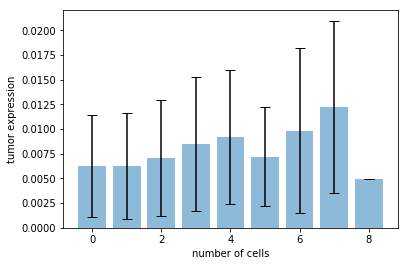

In [21]:
t = np.arange(n_max)
plt.xlabel('number of cells')
plt.ylabel('tumor expression')
plt.bar(t,x_mean, yerr=x_std, align='center', alpha=0.5, ecolor='black', capsize=5)
plt.show()